# Predicting Stock Returns [PyTorch - Seq2Seq] 

In [31]:
import datetime as dt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import requests
import json
import glob
import random
import re
from datetime import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
import matplotlib.pyplot as plt
import warnings
from functools import partial

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     import yfinance as yf
#     from sklearn.cluster import KMeans

path = r'{PATH}'
os.chdir(path)
tqdm = partial(tqdm,position=0,leave=True)
print('done')

done


## 1. Pre-Processing

In [5]:
sp500 = pd.read_csv('processed_df_v1.csv') # Pre-processed
sp500 = sp500.drop(['Year_x','Year_y','grouper1'],axis=1)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['Target'] = sp500.groupby('Stock')['Target'].shift(-1)
sp500['Target_Return'] = sp500.groupby('Stock')['Return'].shift(-1)
sp500['Target_Close'] = sp500.groupby('Stock')['Close'].shift(-1)
rand_stocks = random.choices(sp500['Stock'].unique(),k=10) # For stock sampling later
print('done')

done


In [6]:
# Final Imputation and Troubleshooting for Null & Inf Values
inf_cols = ['Stochastic_5','Stochastic_15','RS_5','RS_15']
for c in inf_cols:
    sp500[c] = sp500[c].replace([np.inf,-np.inf],np.nan)

null_cols = ['SMA_Volume_ratio','Stochastic_5','Stochastic_15','Stochastic_%D_5','Stochastic_%D_15','Stochastic_Ratio',
'+DM_5','-DM_5','+DM_15','-DM_15','RS_5','RS_15','RSI_5','RSI_ratio']
for c in null_cols:
    result = sp500.groupby('Stock')[c].apply(lambda x: x.fillna(x.mean()))
    sp500[c] = result.droplevel(0)

for c in ['Return','Target','Target_Return','Target_Close']:
    sp500[c] = sp500.groupby('Stock')[c].ffill().bfill()
    
num_cols = [c for c in sp500.columns if c not in ['Date','Stock','Year']]
for c in num_cols: 
    if sp500[c].isnull().values.any():
        print('null',c)
    if np.isinf(sp500[c].values).any():
        print('inf',c)
print('done')

done


In [9]:
# Create Explanatory Variable DataFrame
sp500_var = sp500.copy()
sp500_var = sp500_var.drop(['Date','Return','Stock','Target','Target_Return','Target_Close'],axis=1)
print('done')

done


In [7]:
sp500.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,Return,...,United States_CA,United States_CP_end,United States_CP_avg,United States_Gov_NetDebt,United States_GDP,United States_UR,Fed_Rate,Target,Target_Return,Target_Close
0,2000-01-03,1.153400,1.206028,1.023149,1.201642,7226398,0.0,0.0,ATVI,-0.030293,...,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,0.0,-0.030293,1.165241
1,2000-01-04,1.175329,1.187609,1.041570,1.165241,4262390,0.0,0.0,ATVI,-0.030293,...,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,1.0,0.003765,1.169628
2,2000-01-05,1.153401,1.196818,1.151208,1.169628,3389998,0.0,0.0,ATVI,0.003765,...,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,0.0,-0.019498,1.146823
3,2000-01-06,1.162173,1.169628,1.137612,1.146823,2429998,0.0,0.0,ATVI,-0.019498,...,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,1.0,0.027915,1.178837
4,2000-01-07,1.162172,1.187609,1.133228,1.178837,15549590,0.0,0.0,ATVI,0.027915,...,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,1.0,0.050223,1.238042


## 2. Data Pipelines

### 2.1 Preparations (PCA, Data Splits)

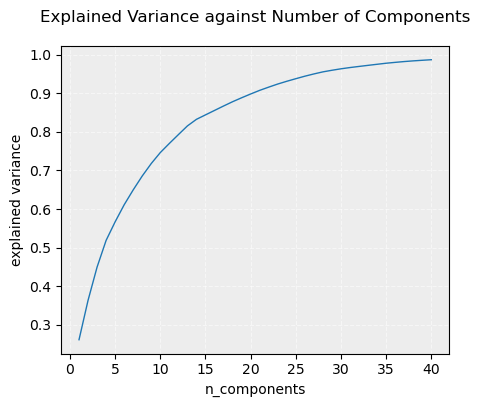

In [17]:
exp_var = pd.DataFrame(columns=['n','var'])
for i in tqdm(range(1,41)):
    pca = PCA(n_components=i)
    pca.fit(sp500_var)
    exp_var.loc[i-1,'n'] = i
    exp_var.loc[i-1,'var'] = np.sum(list(pca.explained_variance_ratio_))
exp_var.to_csv('pca_explained_variance_v1.csv',index=False)

exp_var = pd.read_csv('pca_explained_variance_v1.csv')
plt.figure(figsize=(5,4))
ax = plt.axes()
ax.set_facecolor('0.93')
plt.grid(color='w',linestyle="--",alpha=0.5,zorder=2)
plt.plot(exp_var['n'],exp_var['var'],linewidth=1)
plt.title('Explained Variance against Number of Components',y=1.05)
plt.xlabel('n_components',y=1.05)
plt.ylabel('explained variance')
plt.show() # Choose 30

In [6]:
stock_list = sp500['Stock'].unique()
date_range = sp500['Date'].unique().to_numpy()

def generate_splits(df,stock_list,date_range,constant_range=False):
    n_splits = 3 # Hard-coded for now
    tot_size = len(date_range)
    each_size = tot_size//5
    train_dates_1 = date_range[:2*each_size]
    idx_splits = {}
    for i in range(n_splits):
        if i == 0:
            train_dates = train_dates_1
            test_dates = date_range[(i+2)*each_size:(i+3)*each_size]
        elif i == n_splits-1:
            train_dates = np.append(train_dates_1,date_range[(i+1)*each_size:(i+2)*each_size])
            test_dates = date_range[(i+2)*each_size:]
        else:
            train_dates = np.append(train_dates_1,date_range[(i+1)*each_size:(i+2)*each_size])
            test_dates = date_range[(i+2)*each_size:(i+3)*each_size]
        idx_splits[i] = [[],[]]
        if constant_range == False:
            for s in stock_list:
                temp = df.loc[df['Stock']==s,'Date'].reset_index()
                temp = temp.set_index('Date')
                s_dates = temp.index.values
                s_train_dates = set(train_dates).intersection(set(s_dates))
                s_test_dates = set(test_dates).intersection(set(s_dates))
                if len(s_train_dates) > 0:
                    train_idx = temp.loc[list(s_train_dates),'index'].values
                    idx_splits[i][0].extend(train_idx)
                if len(s_test_dates) > 0:
                    test_idx = temp.loc[list(s_test_dates),'index'].values
                    idx_splits[i][1].extend(test_idx)
        else: # Equivalent to a simple Time Series Split
            for s in stock_list: 
                temp = df.loc[df['Stock']==s,'Date'].reset_index()
                temp = temp.set_index('Date')
                train_idx = temp.loc[list(train_dates),'index'].values
                idx_splits[i][0].extend(train_idx)
                test_idx = temp.loc[list(test_dates),'index'].values
                idx_splits[i][1].extend(test_idx)
    return idx_splits
# 3 splits. Each split: split (3) # x train/test (2) x idx (allocated idx across all stocks)

In [ ]:
idx_splits = generate_splits(sp500,stock_list,date_range)

In [ ]:
# Save idx_splits: for efficiency
idx_splits1 = idx_splits
for a in tqdm(range(len(idx_splits))):
    for b in range(len(idx_splits[a])):
        for c in range(len(idx_splits[a][b])):
            idx_splits1[a][b][c] = str(idx_splits[a][b][c])
with open('idx_splits.json','w') as fp:
    json.dump(idx_splits1,fp)

In [ ]:
# Re-load idx_splits: for efficiency
with open('idx_splits.json') as json_file:
    idx_splits = json.load(json_file)
for a in tqdm(range(len(idx_splits))):
    for b in range(len(idx_splits[str(a)])):
        for c in range(len(idx_splits[str(a)][b])):
            idx_splits[str(a)][b][c] = int(idx_splits[str(a)][b][c])
idx_splits = {int(k):v for k,v in idx_splits.items()}

In [11]:
# Full Dataset (*Run this)
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].to_numpy()
cat_vars = ['Stock']
sp500_var['Stock'] = sp500['Stock']
num_vars = list(set(sp500_var.columns) - set(cat_vars))
print('done')

done


### 2.2 Pipeline for Full Dataset

In [ ]:
# Pipeline for Full Dataset
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_vars)),
    ('scaler',StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_vars)),
    ('ohe',OneHotEncoder()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])
X_processed = full_pipeline.fit_transform(sp500_var)
print('done')

### 2.3 Pipeline for Sampled Dataset

In [ ]:
# Sample Stocks for Smaller Dataset
possible_stocks = []
aapl_dates = set(sp500.loc[sp500['Stock']=='AAPL','Date'].to_numpy())
for s in tqdm(stock_list):
    if set(sp500.loc[sp500['Stock']==s,'Date'].to_numpy()) == aapl_dates:
        possible_stocks.append(s)
print(possible_stocks)

In [12]:
# Pipeline for Sampled Dataset
possible_stocks = ['AAPL','CCI', 'USB', 'ADI', 'PNW', 'QCOM']
sp500_sampled = sp500.loc[sp500['Stock'].isin(possible_stocks)].reset_index(drop=True)
sp500_pca = sp500_sampled.drop(['Target','Target_Return','Target_Close'],axis=1)

num_pipeline1 = Pipeline([
    ('selector',DataFrameSelector(num_vars)),
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=30))
])
cat_pipeline1 = Pipeline([
    ('selector',DataFrameSelector(cat_vars)),
    ('ohe',OneHotEncoder()),
])
full_pipeline1 = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline1),
    ('cat_pipeline',cat_pipeline1),
])
X1 = full_pipeline1.fit_transform(sp500_pca).toarray()
print('done')

# Generate new index splits for smaller dataset
# aapl_date_range = sp500_pca['Date'].unique()
# idx_splits2 = generate_splits(sp500_pca,possible_stocks,aapl_date_range,True)

done


## 3. Seq2Seq with PyTorch

In [2]:
## Ow notes
# Attention (init) - why initial layer input_size = 2 * hidden_size? 
    # -> encoder hidden state ht & current decoder hidden state Z
# Attention (forward) - why need to stack decoder hidden states?
    # Same reason as above ^
    # i.e. each line of input: decoder hidden state and 1 encoder output

# NLP example: 
    # train_data = pair x len(pair)
    # each pair = 1 'batch'
    # train_data = TensorDataSet(input,target)
    # train_dataloader
    # for each batch (i.e. pair): train & optimize
# Forecasting example:
    # train_data: (chronological order x total num of time series) x time steps x number of features

In [22]:
import torch.nn as nn
import torch
import math
from copy import deepcopy

def inverse_sigmoid_decay(decay):
    def compute(idx):
        return decay/(decay + math.exp(idx/decay))
    return compute

calc_teacher_force_prob = inverse_sigmoid_decay(10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print('done')

cuda
done


In [15]:
class DataGenerator_S2S():
    def __init__(self,X,input_seq_len,output_seq_len,k=6):
        self.X = X
        self.k = k
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
    
    def generate_SampledData(self,y1_df,cat_pipeline): # pre-tensor       
        X1_cols = list(np.arange(30))
        X1_cols.extend(cat_pipeline['ohe'].get_feature_names_out())
        X1_df = pd.DataFrame(self.X,columns=X1_cols)
        X1_few = []
        y1_few = []
        for s in tqdm(possible_stocks):
            X1_few.append(X1_df.loc[X1_df[f'x0_{s}']==1].to_numpy())
            y1_few.append(y1_df.loc[y1_df['Stock']==s,'Target'].to_numpy())
        X1_few = np.asarray(X1_few) #(6, 5995, 36)
        y1_few = np.asarray(y1_few)
        return X1_few,y1_few

    def generate_splits(self,X): # assume constant range.
        # Current: stock x timesteps x features
        # Outcome: split # x train/val x dataset type x (seq by time x stock) x timesteps x features
            # Does this result in us training the model with 'future data'?
        k = self.k
        batch_size = X.shape[1]//k
        idx = {'train':[],'val':[],'test':[]}
        idx['test'].append(list(range(batch_size*(k-1),X.shape[1])))
        for i in range(k-3):
            idx['train'].append(list(range(i*batch_size,(i*batch_size) + batch_size)))
            idx['val'].append(list(range((i*batch_size) + batch_size - 1,(i*batch_size) + (2*batch_size))))
        # (train/val x k-3 batches) + test
        self.idx_splits = idx
                            
    def generate_seq(self,X,y):
        # X: stocks x timesteps x features
        # y: stocks x timesteps
        X = torch.tensor(X,dtype=torch.float).to(device)
        y = torch.tensor(y,dtype=torch.float).to(device)
        enc_inputs, dec_inputs, dec_targets = [], [], []
        input_seq_len = self.input_seq_len
        output_seq_len = self.output_seq_len
        for t in range(X.shape[1] - input_seq_len - output_seq_len):
            enc_inputs_at_t = deepcopy(X[:,t:t + input_seq_len,:])
            dec_inputs_at_t = deepcopy(X[:,t + input_seq_len-1:t + input_seq_len + output_seq_len,:])
            dec_targets_at_t = deepcopy(y[:,t + input_seq_len-1:t + input_seq_len + output_seq_len])
            enc_inputs.append(enc_inputs_at_t)
            dec_inputs.append(dec_inputs_at_t)
            dec_targets.append(dec_targets_at_t)
        enc_inputs = torch.stack(enc_inputs); dec_inputs = torch.stack(dec_inputs)
        dec_targets = torch.stack(dec_targets)
        enc_inputs = enc_inputs.reshape(-1,enc_inputs.shape[2],enc_inputs.shape[3])
        dec_inputs = dec_inputs.reshape(-1,dec_inputs.shape[2],dec_inputs.shape[3])
        dec_targets = dec_targets.reshape(-1,dec_targets.shape[2],1)
        return {'enc_inputs':enc_inputs,'dec_inputs':dec_inputs,'dec_targets':dec_targets}
                            
    def generate_trainval(self,X,y):
        # X: the whole X from generate_SampledData
        idx_splits = self.idx_splits
        k = self.k
        i = 0
        while i <= k-3:
            train_idx = idx_splits['train'][i]
            val_idx = idx_splits['val'][i]
            train_data = self.generate_seq(X[:,train_idx,:],y[:,train_idx])
            val_data = self.generate_seq(X[:,val_idx,:],y[:,val_idx])
            i += 1
            yield train_data, val_data 

In [16]:
input_seq_len = 150 #reference to Git sample
output_seq_len = 30 #reference to Git sample
target_size = 1
encoder_input_size = 36
hidden_size = 32
decoder_input_size = 36
lr = 0.00005
# don't need batch_size for now

In [17]:
# inputs: 'batch'(1) x time steps x num features
# output: 'batch'(1) x time steps x num targets (1)
# No teacher forcing for now - because we are currently using pca features, without a specific column position for target returns
class Encoder(nn.Module):
    def __init__(self,encoder_input_size,hidden_size):
        super().__init__()
        self.rnn = nn.RNN(encoder_input_size,hidden_size) # input size: no. of features at time t
    
    def forward(self,encoder_inputs):
        outputs,hidden = self.rnn(encoder_inputs) # Pytorch handles roller behind-the-scenes
        return outputs,hidden
    
class Decoder(nn.Module):
    def __init__(self,decoder_input_size,hidden_size,device):
        super().__init__()
        self.device = device
        self.rnn = nn.RNN(decoder_input_size,hidden_size) # input size: same as encoder_input; also the no. of features at time t
        self.out = nn.Linear(hidden_size,1)
        
    def forward(self,decoder_inputs,encoder_outputs,hidden,targets,teacher_force_probability):
        decoder_sequence_length, _ = decoder_inputs.shape
        # outputs = [None for _ in range(decoder_sequence_length)]
        outputs = torch.zeros(decoder_sequence_length,target_size).to(self.device)
        input_at_t = decoder_inputs[0,:].reshape(1,decoder_inputs.shape[1])
        for t in range(decoder_sequence_length):
            output,hidden = self.rnn(input_at_t,hidden)
            outputs[t,:] = self.out(output)
            # teacher_force = random() < teacher_force_probability
            if t < decoder_sequence_length - 1:
                input_at_t = decoder_inputs[t+1,:].clone().reshape(1,decoder_inputs.shape[1]) #input includes a column with date t target (predicting t+1)
            # if not teacher_force:
            #     input_at_t[:,0] = outputs[t+1,:] #date t target column as first column
        return outputs

class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder,lr):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.optimizer = torch.optim.Adam(self.parameters(),lr)
        self.loss_function = nn.L1Loss()
        
    def forward(self, encoder_inputs, decoder_inputs, targets, teacher_force_probability=None):
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        outputs = self.decoder(decoder_inputs,encoder_outputs,hidden,targets,teacher_force_probability)
        return outputs
    
    def compute_loss(self,outputs,targets):
        loss = self.loss_function(outputs,targets)
        return loss
    
    def optimize(self,outputs,targets):
        self.optimizer.zero_grad()
        loss = self.compute_loss(outputs,targets)
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [18]:
def train(model,train_data,teacher_force_prob):
    model.train()
    epoch_loss = 0
    for i in range(train_data['enc_inputs'].shape[0]):
        encoder_inputs = train_data['enc_inputs'][i,:,:]
        decoder_inputs = train_data['dec_inputs'][i,:,:]
        decoder_targets = train_data['dec_targets'][i,:,:]
        # print(encoder_inputs.shape,decoder_inputs.shape,decoder_targets.shape)
        # torch.Size([6, 150, 36]) torch.Size([6, 31, 36]) torch.Size([6, 31])
        output = model(encoder_inputs, decoder_inputs, decoder_targets, teacher_force_prob)
        loss = model.optimize(output,decoder_targets)
        epoch_loss += loss
    return epoch_loss / train_data['enc_inputs'].shape[0]

def evaluate(model,val_data):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i in range(val_data['enc_inputs'].shape[0]):
            encoder_inputs = val_data['enc_inputs'][i,:,:]
            decoder_inputs = val_data['dec_inputs'][i,:,:]
            decoder_targets = val_data['dec_targets'][i,:,:]
            output = model(encoder_inputs, decoder_inputs, decoder_targets, teacher_force_prob)
            loss = model.compute_loss(output,decoder_targets)
            epoch_loss += loss
    return epoch_loss / val_data['enc_inputs'].shape[0]

In [ ]:
num_epochs = 50
best_val,best_model = float('inf'),None
training_results = pd.DataFrame(columns=['Split','Epoch','Training Loss','Validation Loss','Teacher Forcing Prob','New Best'])
data_generator = DataGenerator_S2S(X1,input_seq_len,output_seq_len)
X_sampled, y_sampled = data_generator.generate_SampledData(sp500_sampled,cat_pipeline1)
data_generator.generate_splits(X_sampled)

encoder = Encoder(encoder_input_size,hidden_size)
decoder = Decoder(decoder_input_size,hidden_size,device)
seq2seq = Seq2Seq(encoder,decoder,lr).to(device)

split = 1
for train_data, val_data in data_generator.generate_trainval(X_sampled,y_sampled):
    for epoch in tqdm(range(num_epochs)):
        teacher_force_prob = calc_teacher_force_prob(epoch)
        train_loss = train(seq2seq,train_data,teacher_force_prob)
        val_loss = evaluate(seq2seq,val_data)
        new_best_val = False
        if val_loss < best_val:
            new_best_val = True
            best_val = val_loss
            best_model = deepcopy(seq2seq)
        # print(training_results, split, epoch, train_loss,val_loss)
        training_results.loc[split*epoch] = [split,epoch+1,train_loss,val_loss.cpu(),teacher_force_prob,new_best_val]
        print(f'Epoch{epoch+1}: Training loss = {train_loss:.5f} ',
              f'Validation loss = {val_loss:.5f}')
    print(f'Split {split} done. Best validation loss = {best_val:.2f}\n')
    split += 1
training_results.to_csv('seq2seq_results_v0.csv',index=False)

### WIP - Not Debugged

In [ ]:
# With Attention

def stack_decoder_hidden(current_decoder_hidden,n):
    stacked_hidden = tuple([current_decoder_hidden for i in range(n)])
    return torch.cat(stacked_hidden)

class Attention(nn.Module):
    def __init__(self,encoder_input_size,hidden_size):
        super().__init__()
        self.initial_layer = nn.Linear(2*hidden_size,hidden_size)
        sef.final_layer - nn.Linear(hidden_size,1)
    
    def forward(self,current_decoder_hidden,encoder_outputs):
        # decoder_hidden_stack = stack_decoder_hidden(current_decoder_hidden,len(encoder_outputs))
        decoder_hidden_stack = current_decoder_hidden.unsqueeze(0).repeat(encoder_outputs.shape[0], 1)
        energy = self.initial_layer(torch.cat((encoder_outputs,decoder_hidden_stack),1))
        energy = torch.tanh(energy)
        energy = self.final_layer(energy).squeeze(1)
        # energy = torch.softmax(energy) 
        weights = torch.softmax(energy)
        attn = torch.mm(weights,encoder_outputs)
        return attn
    
class Decoder_withAttention(nn.Module):
    def __init__(self,decoder_input_size,hidden_size):
        super().__init__()
        self.attention_module = Attention(hidden_size)
        self.rnn = nn.RNN(1 + hidden_size,hidden_size)
        self.out = nn.Linear(hidden_size,1)
        
    def forward(self,decoder_inputs,encoder_outputs,hidden,targets,teacher_force_probability)
        decoder_sequence_length = len(targets)
        outputs = [None for _ in range(decoder_sequence_length)] #?
        input_at_t = decoder_inputs[0] #?
        for t in tqdm(range(decoder_sequence_length)):
            attention_vector = self.attention_module(hidden,encoder_outputs)
            cat_input = torch.cat((input_at_t, attention_vector))
            output,hidden = self.rnn(cat_input,hidden)
            outputs[t] = self.out(output)
            teacher_froce = random() < teacher_force_probability
            input_at_t = decoder_inputs[t+1] if teacher_force 
                else outputs[t] + decoder_inputs[t+1][1:]
        return outputs